# Lekce 10

Rozhodovací stromy jou dalším z algoritmů, které můžeme používat ke klasifikaci. Jejich obrovskou výhodou je, že jsou velmi snadno interpretovatelné. To znamená, že uživatel může snadno zjistit, proč algoritmus přiřadil záznam k dané skupině.

Scikit-learn umí graf exportovat ve formátu aplikace Graphviz. Pro ni pak existuje modul, který umí vykreslit rozhodovací strom jak obrázek.

- Nejprve je potřeba stáhnout software Graphviz [zde](https://graphviz.org/download/).
- Následně je potřeba nainstalovat modul `pydotplus` příkazem `pip install pydotplus`.

In [107]:
import pandas
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus
from pydotplus import graph_from_dot_data

Budeme pracovat s daty v souboru [titanic.csv](titanic.csv), která obsahují data o pasažérech Titanicu. Náš model bude predikovat, jestli pasažér(ka) potopení Titanicu přežil(a).

In [108]:
data = pandas.read_csv("titanic.csv")
data.head()

,sex,age,sibsp,parch,fare,embarked,class,who,alone,survived
0,male,22.0,1,0,7.2500,S,Third,man,False,0
1,female,38.0,1,0,71.2833,C,First,woman,False,1
2,female,26.0,0,0,7.9250,S,Third,woman,True,1
3,female,35.0,1,0,53.1000,S,First,woman,False,1
4,male,35.0,0,0,8.0500,S,Third,man,True,0


Aby náš první strom byl co nejjenodušší, budeme pasažéry rozdělovat pouze podle pohlaví. Do tabulky `X` tedy vložíme pouze sloupec `sex` a do série `y` sloupec `survived`.

In [109]:
feature_cols = ["sex"]

X = data[feature_cols]
y = data["survived"]

Rozhodovací strom si sám o sobě neporadí s textovými zápisy pohlaví, využijeme proto `OneHotEncoder`. Výsledek převedeme na typ pole (`array`) pomocí metody `toarray()`, abychom si mohli prohlédnout výsledek.  Pole je základní datovou strukturou, která je převzatá z modulu `numpy`. Na rozdíl od tabulky v `pandas` je pole poněkud jednodušší strukturou - například neobsahuje index, nepodporuje dotazy a nejde přímo uložit do souboru. Díky jejich jednoduchosti je však práce s nimi rychlejší.

Podívejme se nyní na obsah pole `X`. Vidíme, že vy výstupu máme dva sloupce. V každém řádku najdeme vždy jednu hodnotu 0.0 a jednu hodnotu 1.0. Pořadí závisí na tom, jestli je daná osoba muž nebo žena.

In [110]:
encoder = OneHotEncoder()
X = encoder.fit_transform(X)
X = X.toarray()
X

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

Pole nemá názvy sloupečků. Pokud bychom je ale potřebovali, můžeme je zjistit z proměnné `encoder`, a to pomocí metody `get_feature_names_out()`.

In [111]:
encoder.get_feature_names_out()

array(['sex_female', 'sex_male'], dtype=object)

Data si na testovací a trénovací sadu rozdělíme ručně, protože nevyužíváme `GridSearchCV`.

In [112]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

Dále vytvoříme `DecisionTreeClassifier`, což je klasifikátor využívající algoritmus rozhodovacího stromu. Necháme nastavené výchozí parametry.

In [113]:
clf = DecisionTreeClassifier(random_state=42)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Dále vygenerujeme grafický výstup. Využijeme funkci `export_graphviz`. Abychom si obrázek mohli prohlédnout Jupyter notebooku, využijeme následující příkazy. Výsledkem je obrázek, který se zobrazí v Jupyter notebooku.

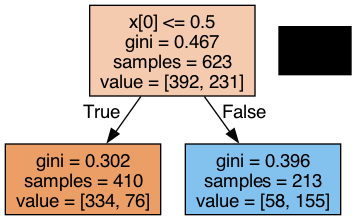

In [114]:
# Vytvoření objektu StringIO, který je jakousi "virtuální" souborovou strukturou v paměti.
# Tento objekt bude použit pro ukládání struktury rozhodovacího stromu.
dot_data = StringIO()
# Funkce export_graphviz z knihovny sklearn se používá pro konverzi rozhodovacího stromu
# do DOT formátu, což je grafický jazyk používaný pro popis grafů a stromů. Parametr out_file určuje,
# kam se výsledek uloží - v tomto případě do naší StringIO instance dot_data. Parametr filled=True znamená,
# že uzly stromu budou vyplněny barvou, což může pomoci vizualizovat hodnoty v uzlech.
export_graphviz(clf, out_file=dot_data, filled=True)
# Tento řádek kódu používá knihovnu pydotplus k převedení DOT dat do formátu, který lze využít pro vytvoření obrázku.
# Metoda getvalue() naší instance StringIO (dot_data) se používá pro získání celého obsahu jako jednoho řetězce.
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# Tento poslední řádek vytváří obrázek stromu ve formátu PNG. Funkce Image pochází z knihovny IPython
# a slouží pro zobrazení obrázku přímo v notebooku Jupyter. Metoda create_png() na objektu graph generuje samotný obrázek.
Image(graph.create_png())

Pokud Jupyter notebooku nepoužíváme nebo pokud chceme uložit strom jako obrázek (např. pro vložení do blogového článku), příkaz upravíme. Použijeme metodu `write_png()` a jako parametr zadáme jméno souboru, kam chceme obrázek uložit. Přípona souboru by měla být `.png`, což je oblíbený grafický formát pro ukládání obrázků.

In [115]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("tree.png")

True

Označení "strom" vychází z části matematiky, která se nazývá teorie grafů. My se jí zabývat nebudeme, ale popíšeme si jeho strukturu a pojmy, které se k jejímu popisu používají.

Nahoře je tzv. vrchol, z něhož vychází dvě hrany. Tento vrchol má dva potomoky. Ti sami už žádné potomky nemají, vrcholy bez potomků pak značujeme jako listy. Každý z vrcholů (kromě listů) je místem, kde se musíme rozhodnout, kterou z hran budeme pokračovat.

Jednotlivé typy uzlů jsou shrnuty na obrázku níže. Máme tam:

- root node (kořen),
- decision node (rozhodovací vrchol),
- leaf (list).

![A-Sample-Decision-Tree-Visualized-1024x712.png](A-Sample-Decision-Tree-Visualized-1024x712.png)

Rozhodnutí provádíme na základě záznamů, který chceme klasifikovat. V našem případě se rozhodnujeme pouze na základě pohlaví (nic dalšího v datech nemáme). Rozhodujeme se podle prvního řádku popisu uzlu. Zde je ale dost tajemný výraz `X[0] <= 0.5`. Abychom zjistili, co tento výraz znamená, doplnímu do grafu popisku sloupců (`features`) našich dat. Tyto popisky zázkáme od `encoder`, který s nimi manipuloval. Slouží k tomu metoda `get_feature_names_out()`, kterou jsme si už ukazovali. Výsledek volání metody přidáme jako parametr `feature_names` funkci `export_graphviz`.

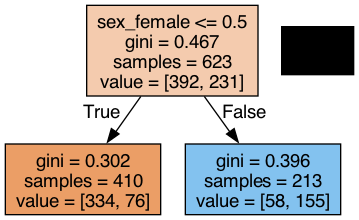

In [116]:
dot_data = StringIO()
export_graphviz(
    clf, out_file=dot_data, filled=True, feature_names=encoder.get_feature_names_out()
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Nyní již vidíme, že v kořenu je `sex_female` (případně tam může být `sex_male`, oba dva sloupce poskytují stejnou informaci). Pokud je v tomto sloupci 0, pak je pasažér muž, pokud je ve sloupci 1, pak je pasažér žena. My bychom chtěli klasifikovat muže, vybíráme tedy variantu `True` (tj. je pravda, že ve sloupci `sex_female` by měl pasažér 0). Další vrchol je list, protože nemá potomky. Nyní musíme provést rozhodnutí, do jaké skupiny pasažéra zařadit. Ve druhém řádku listu vidíme, že mužů bylo v trénovacích datech `406` a v posledním řádku dále vidíme `value = [339, 67]`. To jsou počty pozorování dle hodnot výstupní proměnné. Hodnotu 0 výstupní proměnné má 339 (pomět mužů, kteří zahynuli) a hodnotu 1 výstupní proměnné má 67 (počet mužů, kteří přežili). Muže bychom tedy zařadili do skupiny těch, kteří nepřežili.

Přehlednost zobrazení zvýší, pokud doplníme parametr `class_names`. Pak uvidíme třídu, kterou rozhodovací strom predikuje, v posledním řádku.

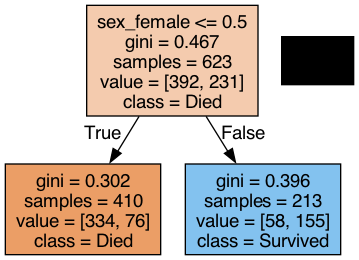

In [117]:
dot_data = StringIO()
export_graphviz(
    clf,
    out_file=dot_data,
    filled=True,
    feature_names=encoder.get_feature_names_out(),
    class_names=["Died", "Survived"],
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### Čtení na doma - gini

Pokud máme v datech více různých sloupců, modul `scikit-learn` se musí nějak rozhodnout, jak strom vytvořit. Jednou z možností, jak vybrat vhodný sloupec, je koeficient `gini`. Ten je jakýmsi měřítkem "různorodosti" dat v daném uzlu. Například v jednom vrcholu je 334 zemřelých a 76 přeživších a ve druhém vrcholu je 58 zemřelých a 155 přeživších. V jednom z vrcholů tedy v početnější skupině relativně více pozorování než v té méně početné, proto je koeficient gini pro tento rozhodovací vrchol menší.

$$
gini = 1 - \sum(\pi_k^2)
$$

$\pi_k$ je pravděpodobnost, že pozorování patří do skupiny $k$. Vypočítáme ji tak, že vydělíme počet pozorování ve skupině $k$ celkovým počtem pozorování v celém uzlu. Například počet zemřelých v pravém uzlu je 334 a celkový počet pozorování je 410, pravděpodobnost $\pi = \frac{334}{410}=0.8146$ (tj. v trénovacím vzorku máme 81.46 % mrtvých mužů). Pravděpodobnost pak umocnímě na druhou. Stejný výpočet provedeme pro všechny skupiny, výsledky sečteme a odečteme od 1.

Níže je příklad výpočtu pro pravý list.

In [118]:
334 / 410

0.8146341463414634

In [119]:
1 - ((334 / 410) ** 2 + (76 / 410) ** 2)

0.30201070791195717

Je možné se podle takového koeficientu rozhodnout? Uvažujme, že bychom získali list, kde jsou obě skupiny zastoupeny rovnoměrně, tj. máme 203 přeživších a 203 zemřelých. Takové dělení by bylo k ničemu, protože se z něj nic nedozvíme. Nebudeme umět přiřadit pozorování do žádné skupiny.

In [120]:
1 - ((203 / 406) ** 2 + (203 / 406) ** 2)

0.5

Pokud bychom naopak měli všechna pozorování v jedné skupině, je takové dělení ideální, protože nám jasně oddělilo obě skupiny. V takovém případě by byl gini koeficient 0.

In [121]:
1 - ((406 / 406) ** 2 + (0 / 406) ** 2)

0.0

Strom tedy budeme vykreslovat tak, abychom dosáhli co nejnižšího gini koeficientu, což nám zajistí, že rozdíl mezi oběma skupinami bude co největší.

### Přidání dalších sloupců

Nyní do stromu přidáme další proměnou, pomocí které bude strom predikovat, a to třída, ve které každá z osob cestovala. Vidíme, že strom se docela rozrostl.

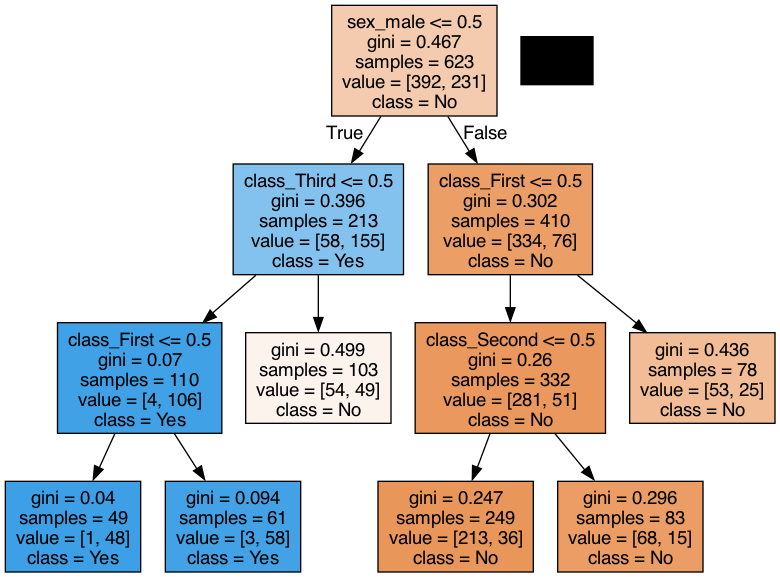

In [122]:
feature_cols = ["sex", "class"]

X = data[feature_cols]
y = data["survived"]

encoder = OneHotEncoder()
X = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

clf = DecisionTreeClassifier(random_state=42)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


dot_data = StringIO()
export_graphviz(
    clf,
    out_file=dot_data,
    filled=True,
    feature_names=encoder.get_feature_names_out(),
    class_names=["No", "Yes"],
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

U rozhodovacího stromu můžeme, podobně jako u ostatních algoritmů, nastavovat parametry. U rozhodovacího stromu můžeme měnit tyto:

- `max_depth` = hloubka stromu ("počet pater" stromu),
- `min_samples_split` = minimální počet vzorků pro rozdělení (pokud bude mít vrchol méně, nepůjde dále rozdělit a stane se listem).

Proč tyto parametry řešit?

Výchozí hodnota parametru `max_depth` je `None`, což znamená, že neexistuje žádný limit výška stromu. Strom tak může být velmi komplexní a může vyústit v problém označovaný jako **overtiffint**. Overfitting je běžný problém v strojovém učení, který nastává, pokud se model příliš dobře přízpůsobí trénovacím datům. To vede k tomu, že model je nedostatečně schopen generalizovat na nová, dosud neviděná data. Overfitting se často projevuje tím, že model má vysokou přesnost na tréninkových datech, ale nízkou přesnost na testovacích datech. Nastavení maximální výšky stromu omezí komplexnost stromu a též může snížit overfitting, protože klasifikace je pak založena na menší kombinaci hodnot jednotlivých sloupců.

Overfitting může omezit též `min_samples_split`, protože brání tomu, aby bylo rozhodnutí činěno na příliš malém množství pozorování. Rozhodnutí založené na jednotkách pozorování může být navázána na příliš specifické vlastnosti trénovací sady dat.

Nejprve zkusíme omezit výšku stromu na 2.

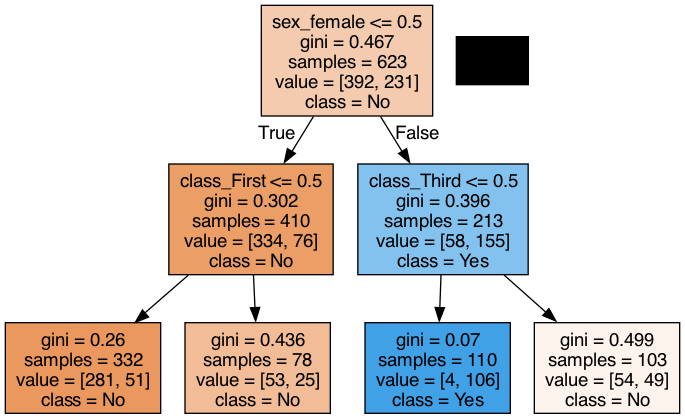

In [123]:
feature_cols = ["sex", "class"]

X = data[feature_cols]
y = data["survived"]

encoder = OneHotEncoder()
X = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Strom může mít maximálně 2 patra (kořen nepočítáme)
clf = DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


dot_data = StringIO()
export_graphviz(
    clf,
    out_file=dot_data,
    filled=True,
    feature_names=encoder.get_feature_names_out(),
    class_names=["No", "Yes"],
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Následně zkusíme omezit dělení vrcholů na vrcholy o minimálním počtu 40 pozorování.

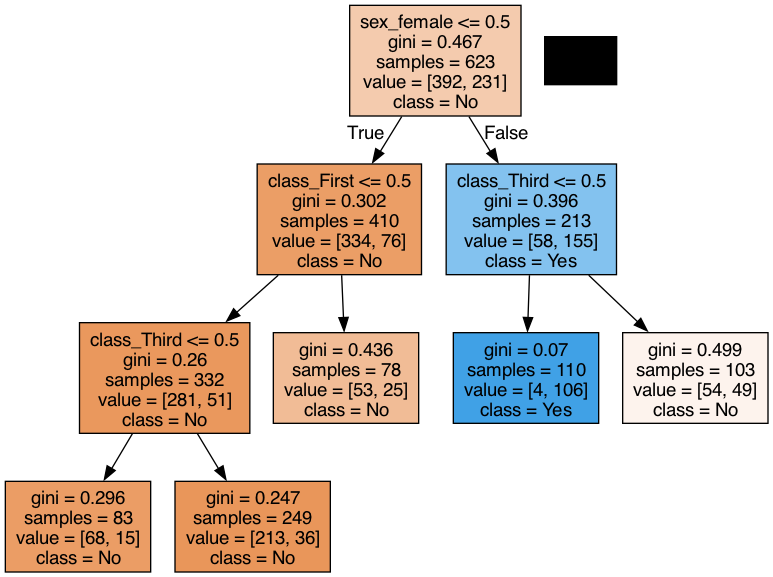

In [124]:
feature_cols = ["sex", "class"]

X = data[feature_cols]
y = data["survived"]

encoder = OneHotEncoder()
X = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Uzly s méně než 100 vzorky již nejdou rozdělit
clf = DecisionTreeClassifier(min_samples_split=150)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


dot_data = StringIO()
export_graphviz(
    clf,
    out_file=dot_data,
    filled=True,
    feature_names=encoder.get_feature_names_out(),
    class_names=["No", "Yes"],
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Přidání zbylých proměnných

Nyní přidáme další proměnné. Budeme se držet čistě kategoriálních proměnných. Namísto `sex` použijeme `who`, což je sloupec, který rozděluje osoby na muže, ženy a děti. Strom, který tento kód vygeneruje, je opravdu gigantický a určitě by se nám jen nepovedlo například rozumně vytisknout na stránku o velikosti A4. To ale nevadí, řada komplexních dat vede ke komplexnímu rozhodovacímu stromu. Pokud potřebujeme strom menší (např. aby byl více přehledný), můžeme použít parametry, které jsme si ukazovali výše.

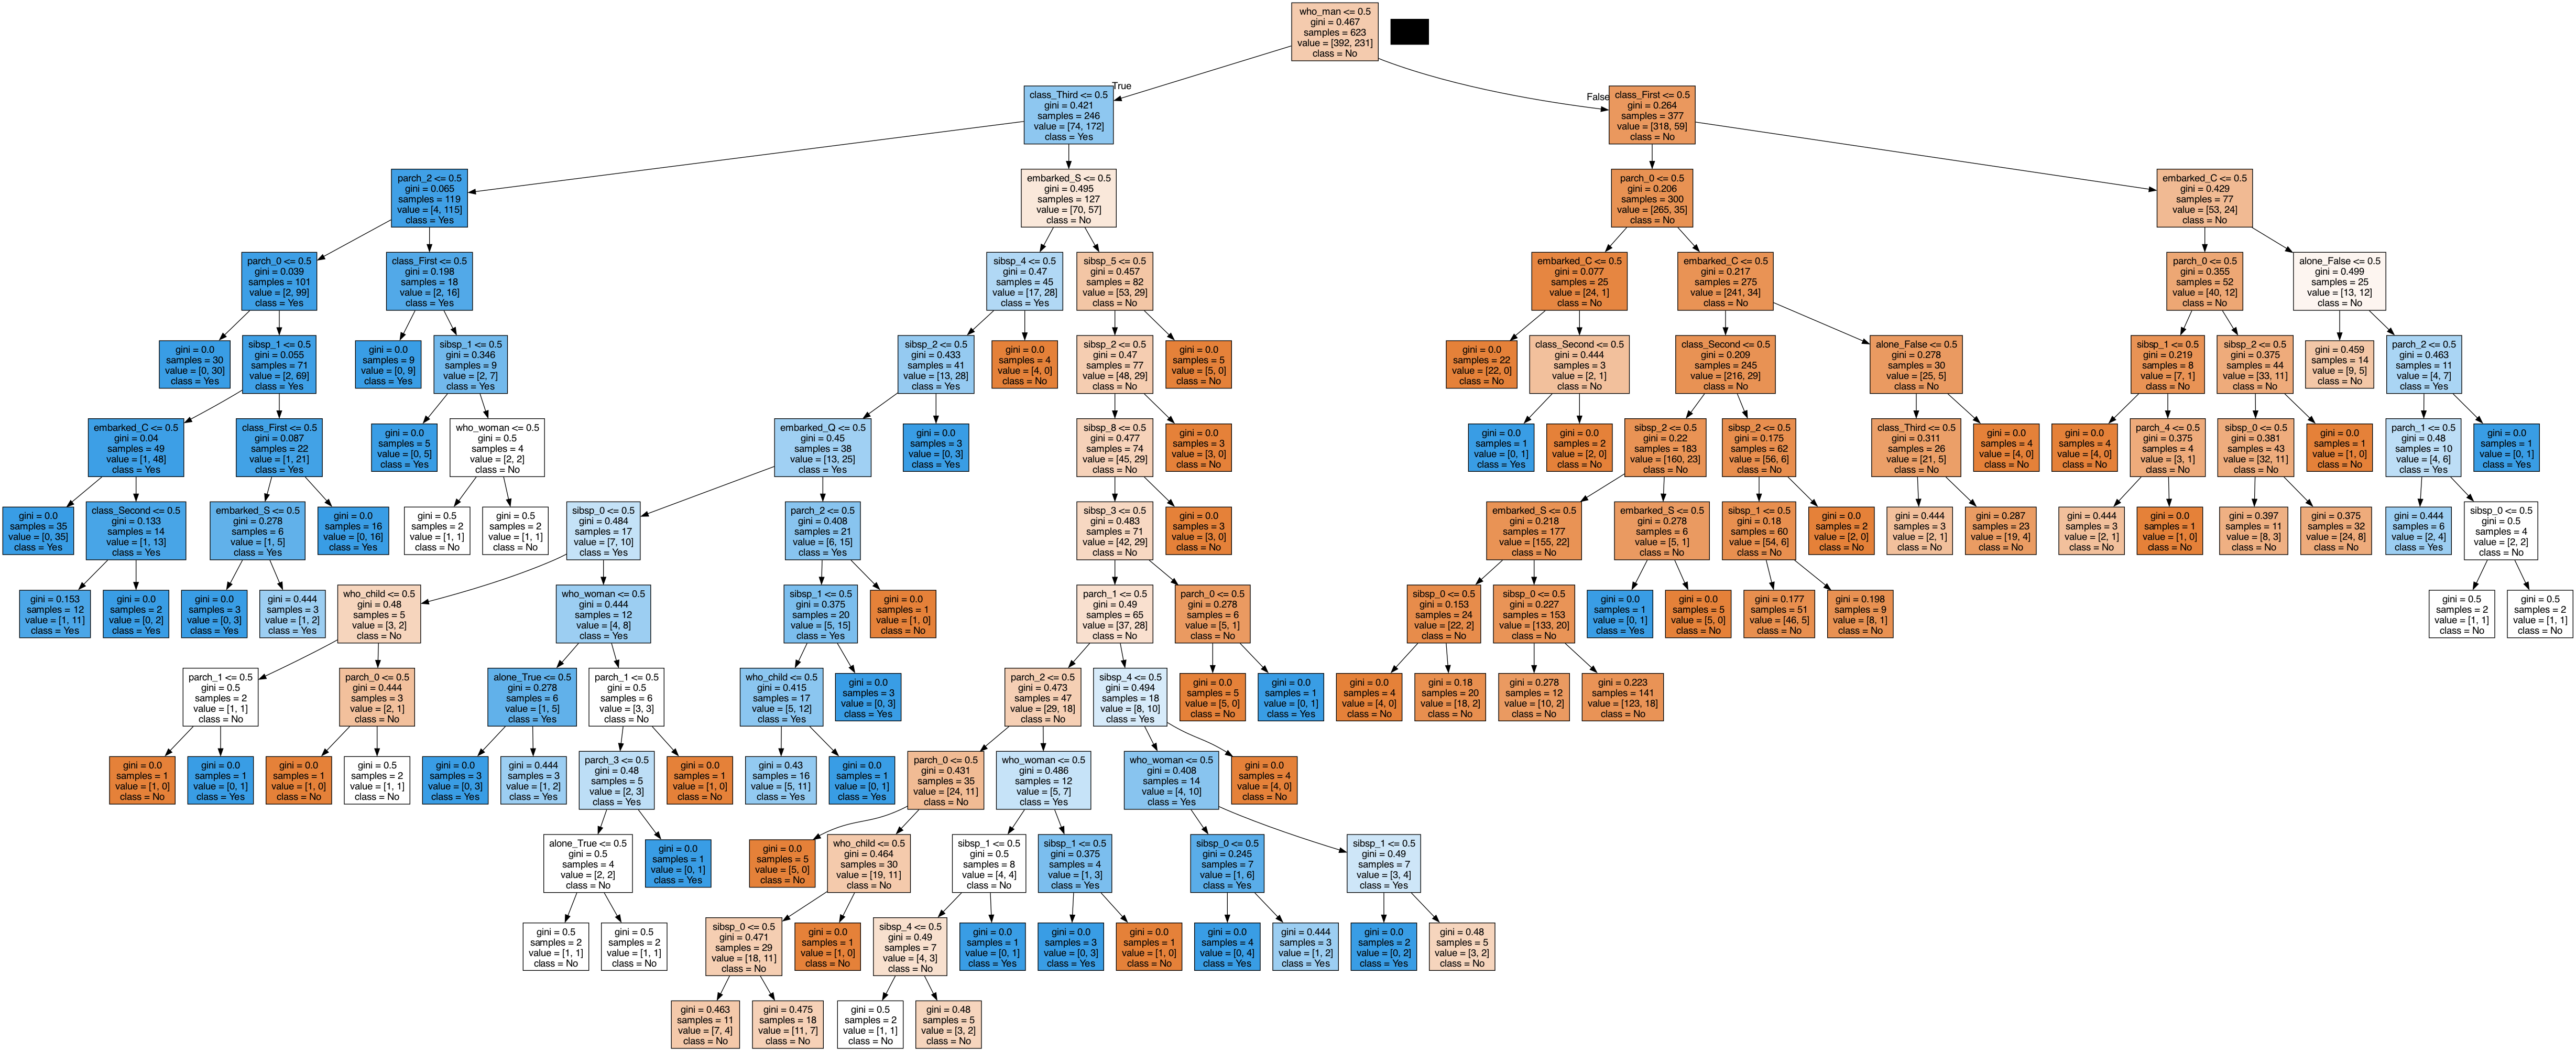

In [125]:
feature_cols = ["sibsp", "parch", "embarked", "class", "who", "alone"]

X = data[feature_cols]
y = data["survived"]

encoder = OneHotEncoder()
X = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

dot_data = StringIO()
export_graphviz(
    clf,
    out_file=dot_data,
    filled=True,
    feature_names=encoder.get_feature_names_out(),
    class_names=["No", "Yes"],
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Kvalitu predikcí takto gigantického stromu můžeme ověřit pomocí matice záměn, která má stejnou strukturu a stejnou interpretaci jako v předchozích lekcí.

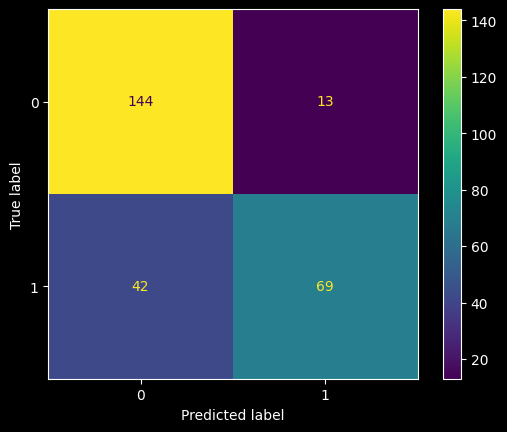

In [126]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

Též můžeme spočítat všechny metriky, které jsme si již ukázali.

In [127]:
accuracy_score(y_test, y_pred)

0.7947761194029851

In [128]:
precision_score(y_test, y_pred)

0.8414634146341463

In [129]:
recall_score(y_test, y_pred)

0.6216216216216216

### Kombinace číselných a kategoriálních proměnných

V našem datasetu máme i numerický sloupec, který označuje cenu jízdenky. Na tento údaj nepotřebujeme použít `OneHotEncoder()`. Proto vytvoříme dva seznamy sloupců:

- `categorical_columns`, kam uložíme sloupce s kategorickými hodnotami,
- `numeric_columns`, kam uložíme sloupce (resp. sloupec) s numerickými hodnotami.

In [130]:
import numpy

y = data["survived"]

categorical_columns = ["sibsp", "parch", "embarked", "class", "who", "alone"]
numeric_columns = ["fare"]

Z tabulky `data` vybereme sloupce v seznamu `others` a převedeme je na pole s využitím metody `to_numpy()`. 

In [131]:
others = data[numeric_columns].to_numpy()

Následně sloupce v seznamu `categorical_columns` upravíme pomocí `OneHotEncoder`.

Je to trochu nešťastné, ale metody na převod na matici se jmenují v modulech `scikit-learn` a `pandas` různě.

- V modulu `scikit-learn` používáme metodu `to_numpy()`
- V modulu `pandas` používáme metodu `toarray()`.

In [132]:
ohe = OneHotEncoder()
encoded_columns = ohe.fit_transform(data[categorical_columns])
encoded_columns = encoded_columns.toarray()

In [133]:
type(others)

numpy.ndarray

In [134]:
type(X)

scipy.sparse._csr.csr_matrix

Nakonec obě pole spojíme do jednoho pomocí funkce `numpy.concatenate()`. Tato funkce je jakousi "hloupější" verzí funkce `merge()`, kterou známe z `pandas`. Spojuje dvě matice do jedné na základě čísla řádků, tj. vezme nultý řádek z obou polí a vytvoří z něj jeden dlouhý řádek v nové matici, to samé s prvním řádkem atd.

In [135]:
X = numpy.concatenate([encoded_columns, others], axis=1)

Na konci data opět rozdělíme na trénovací a testovací.

In [136]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Výsledky rozhodovacího stromu můžeme zobrazit pomocí matice záměn. Ta funguje stejně jako u předchozích algoritmů.

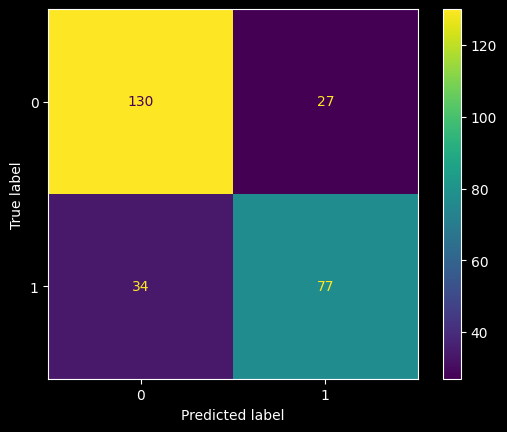

In [137]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

Podobně můžeme určitě i metriky modelu.

In [138]:
accuracy_score(y_test, y_pred)

0.7723880597014925

In [139]:
precision_score(y_test, y_pred)

0.7403846153846154

In [140]:
recall_score(y_test, y_pred)

0.6936936936936937

### Hledání nejlepší parametrů

Ke hledání nejlepší parametrů opět využijeme `GridSearchCV`

In [141]:
model = DecisionTreeClassifier()
params = {"max_depth": [3, 4, 5, 6, 7, 8, 9, 10], "min_samples_split": [10, 20, 30, 40]}

clf = GridSearchCV(model, params, scoring="accuracy")
clf.fit(X, y)

print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 6, 'min_samples_split': 20}
0.8406251961584331


## Zdroje

* [Decision Tree Classifier with Sklearn in Python](https://datagy.io/sklearn-decision-tree-classifier/)
* [Decision Tree Classification in Python Tutorial](https://www.datacamp.com/tutorial/decision-tree-classification-python)
* [How to tune a Decision Tree?](https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680)